In [ ]:
!pip install unidecode googletrans
!pip install squarify

In [ ]:
import re
import time
import tweepy
import folium
import squarify 
import warnings
import collections
import numpy as np
import pandas as pd
from PIL import Image
from folium import plugins
from datetime import datetime
from textblob import TextBlob
import matplotlib.pyplot as plt
from unidecode import unidecode
from googletrans import Translator
from geopy.geocoders import Nominatim
from wordcloud import WordCloud, STOPWORDS

In [ ]:
# Adicione suas credenciais para a API do Twitter

CONSUMER_KEY = CONSUMER_KEY
CONSUMER_SECRET = CONSUMER_SECRET
ACCESS_TOKEN = ACCESS_TOKEN
ACCESS_TOKEN_SECRET = ACCESS_TOKEN_SECRET

# Implementação da classe para obter os tweets

In [202]:
class TweetAnalyzer():

  def __init__(self, consumer_key, consumer_secret, access_token, access_token_secret):
    '''
      Conectar com o tweepy
    '''
    auth = tweepy.OAuthHandler(consumer_key, consumer_secret)
    auth.set_access_token(access_token, access_token_secret)

    self.conToken = tweepy.API(auth, wait_on_rate_limit=True, wait_on_rate_limit_notify=True, retry_count=5, retry_delay=10)
  
  def __clean_tweet(self, tweets_text):
    '''
    Tweet cleansing.
    '''

    return tweets_text.replace("\n", " ")

  def search_by_keyword(self, keyword, count=10, result_type='mixed', lang='en', tweet_mode='extended'):
    '''
      Search for the twitters thar has commented the keyword subject.
    '''
    tweets_iter = tweepy.Cursor(self.conToken.search,
                          q=keyword, tweet_mode=tweet_mode,
                          rpp=count, result_type=result_type,
                          since=datetime(2020,7,31,0,0,0).date(), until=datetime(2020,8,7,0,0,0).date(),
                          lang=lang, include_entities=True).items(count)

    return tweets_iter

  def prepare_tweets_list(self, tweets_iter):
    '''
      Transforming the data to DataFrame.
    '''

    tweets_data_list = []
    for tweet in tweets_iter:
      if not 'retweeted_status' in dir(tweet):
        tweet_text = self.__clean_tweet(tweet.full_text)
        tweets_data = {
            'len' : len(tweet_text),
            'ID' : tweet.id,
            'User' : tweet.user.screen_name,
            'UserName' : tweet.user.name,
            'UserLocation' : tweet.user.location,
            'TweetText' : tweet_text,
            'Language' : tweet.user.lang,
            'Date' : tweet.created_at,
            'Source': tweet.source,
            'Likes' : tweet.favorite_count,
            'Retweets' : tweet.retweet_count,
            'Coordinates' : tweet.coordinates,
            'Place' : tweet.place 
        }

      tweets_data_list.append(tweets_data)

    return tweets_data_list

  def sentiment_polarity(self, tweets_text_list):
      tweets_sentiments_list = []

      for tweet in tweets_text_list:
        polarity = TextBlob(tweet).sentiment.polarity
        if polarity > 0:
          tweets_sentiments_list.append('Positive')
        elif polarity < 0:
          tweets_sentiments_list.append('Negative')
        else:
          tweets_sentiments_list.append('Neutral')

      return tweets_sentiments_list

In [203]:
analyzer = TweetAnalyzer(consumer_key = "3FxJM7gDYDVWNfnhFk56eo1e7", consumer_secret = "Ai9AyBxeVvQY9K3a7oQvq7LYipdBs5oVUZu7fimo7pqr4g2Gx6", access_token = "1289005592019963905-Ikkuxzd4CbkPGvxAkeEpOhU7TPrhyr", access_token_secret = "9A5BZMD0dXF01ydRGKMrBRk1geOCJVS0AuAgPCfmHp63X")
keyword = ("'Black is King' OR 'black is king' OR 'Beyonce' OR 'beyonce' OR #blackisking OR '#BlackIsKing' OR 'black is king beyonce'")

tweets_iter = analyzer.search_by_keyword(keyword, 200)
tweets_data_list = analyzer.prepare_tweets_list(tweets_iter)


In [204]:
tweets_df = pd.DataFrame(tweets_data_list)

# Análises

## Qual o tweet mais curtido e retweetado?


In [ ]:
likes_max = np.max(tweets_df['Likes'])

likes = tweets_df[tweets_df.Likes == likes_max].index[0]

print(f"O tweet com mais curtidas é: {tweets_df['TweetText'][likes]}")
print(f"Numero de curtidas: {likes_max}")
print(np.sum(tweets_df['Likes'] == likes_max))

O tweet com mais curtidas é: BLACK IS KING @Beyonce https://t.co/hewWRJ61CZ
Numero de curtidas: 14188
1


In [ ]:
retweet_max = np.max(tweets_df['Retweets'])

retweet = tweets_df[tweets_df.Retweets == retweet_max].index[0]

print(f"O tweet com mais retweets é: {tweets_df['TweetText'][retweet]}")
print(f"Numero de curtidas: {retweet_max}")
print(np.sum(tweets_df['Retweets'] == retweet_max))

O tweet com mais retweets é: BLACK IS KING @Beyonce https://t.co/hewWRJ61CZ
Numero de curtidas: 2607
1


## Qual a porcentagem dos sentimentos captado?

In [ ]:
tweets_df['Sentiment'] = analyzer.sentiment_polarity(tweets_df['TweetText'])

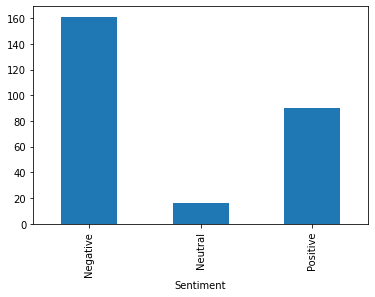

In [ ]:
tweets_df.groupby('Sentiment')['ID'].nunique().plot(kind='bar')
plt.show()

In [ ]:
a = tweets_df[tweets_df['Sentiment'] == 'Negative']

## Quais as palavras mais atribuídas?

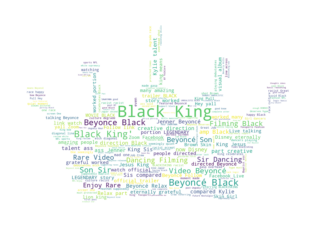

In [ ]:
words = ' '.join(tweets_df['TweetText'])

words_clean = " ".join([word for word in words.split()
                              if 'https' not in word
                                 and not word.startswith('@')
                                 and word != 'RT'
                        ])

warnings.simplefilter('ignore')

mask = np.array(Image.open('crown.png'))
wc = WordCloud(stopwords=STOPWORDS, mask=mask,
               max_words=1000, max_font_size=100,
               min_font_size=10, random_state=42,
               background_color='white', mode="RGB",
               width=mask.shape[1], height=mask.shape[0],
               normalize_plurals=True).generate(words_clean)

plt.imshow(wc, interpolation="bilinear")
plt.axis("off")
plt.savefig('black_is_king_cloud.png', dpi=300)
plt.show()

## Quais são as fonte de tweets mais utilizados?

In [226]:
# Calcular quantidade de source
source_list = tweets_df['Source'].tolist()
occurrences = collections.Counter(source_list)

source_df = pd.DataFrame({'Total':list(occurrences.values())}, index=occurrences.keys())
sources_sorted = source_df.sort_values('Total', ascending=True)

In [ ]:
# Plotar gráfico
plt.style.use('ggplot')
plt.rcParams['font.sans-serif'] = 'Helvetica'
plt.rcParams['axes.edgecolor']='#333F4B'
plt.rcParams['axes.linewidth']=0.8
plt.rcParams['xtick.color']='#333F4B'
plt.rcParams['ytick.color']='#333F4B'
my_range=list(range(1,len(sources_sorted.index)+1))

ax = sources_sorted.Total.plot(kind='barh',color='#1f77b4', alpha=0.8, linewidth=5, figsize=(12,12))
ax.get_xaxis().set_major_formatter(plt.FuncFormatter(lambda x, loc: "{:,}".format(int(x))))

plt.savefig('source_tweets.png', bbox_inches='tight', pad_inches=0.5)

In [ ]:
squarify.plot(sizes=sources_sorted['Total'], label=sources_sorted.index, alpha=.5)
plt.axis('off')
plt.show() 

## De quais regiões vieram os tweets

In [ ]:
geolocator = Nominatim(user_agent="TweeterSentiments")

latitude = []
longitude = []

for user_location in tweets_df['UserLocation']:
  try:
    location = geolocator.geocode(user_location)
    latitude.append(location.latitude)
    longitude.append(location.longitude)
  except:
    continue

coordenadas = np.column_stack((latitude, longitude))

mapa = folium.Map(zoom_start=3.)
mapa.add_child(plugins.HeatMap(coordenadas))
mapa.save('Mapa_calor_tweets.html')

mapa

## Análise temporal dos tweets

findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.


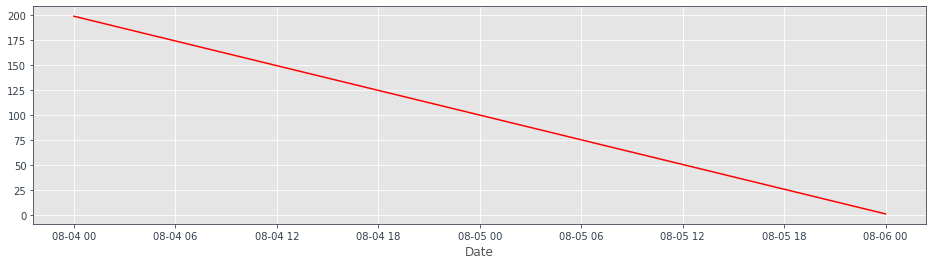

In [234]:
data = tweets_df

data['Date'] = pd.to_datetime(data['Date']).apply(lambda x: x.date())
tlen = pd.Series(data['Date'].value_counts(), index=data['Date'])

tlen.plot(figsize=(16,4), color='r')